# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [3]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/complaints.csv",
    metadata_columns=[
      "Date received", 
      "Product", 
      "Sub-product", 
      "Issue", 
      "Sub-issue", 
      "Consumer complaint narrative", 
      "Company public response", 
      "Company", 
      "State", 
      "ZIP code", 
      "Tags", 
      "Consumer consent provided?", 
      "Submitted via", 
      "Date sent to company", 
      "Company response to consumer", 
      "Timely response?", 
      "Consumer disputed?", 
      "Complaint ID"
    ]
)

loan_complaint_data = loader.load()

for doc in loan_complaint_data:
    doc.page_content = doc.metadata["Consumer complaint narrative"]

Let's look at an example document to see if everything worked as expected!

In [4]:
loan_complaint_data[0]

Document(metadata={'source': './data/complaints.csv', 'row': 0, 'Date received': '03/27/25', 'Product': 'Student loan', 'Sub-product': 'Federal student loan servicing', 'Issue': 'Dealing with your lender or servicer', 'Sub-issue': 'Trouble with how payments are being handled', 'Consumer complaint narrative': "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'Company public response': 'None', 'Company'

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [5]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    loan_complaint_data,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [6]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [8]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [9]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [10]:
naive_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issues with loans appear to be related to mismanagement and bad information from lenders or servicers. Specific frequent problems include errors in loan balances, incorrect or inconsistent loan status reports, misapplication of payments (most often applying payments toward interest rather than principal), and mishandling of loan status (such as incorrectly reporting a loan as delinquent or in default). These issues often cause confusion, financial hardship, and damage to credit scores for borrowers.'

In [11]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, according to the provided complaints, at least one complaint was not handled in a timely manner. Specifically, complaint ID 12709087 filed with MOHELA received a response marked as "No" for timely response, indicating it was not addressed within the expected timeframe.'

In [12]:
naive_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People often fail to pay back their loans due to a combination of factors highlighted in the complaints. These include:\n\n1. **Lack of clear and adequate communication** from loan servicers, leading borrowers to be unaware of their repayment obligations or changes in their loan status. For example, some borrowers reported not receiving notifications or being kept in the dark about loan transfers or delinquency status.\n\n2. **Financial hardships** making it impossible to keep up with payments. Borrowers described difficulties such as stagnant wages, high living expenses, or unexpected financial crises, which prevent them from making payments without risking their basic needs.\n\n3. **Unfavorable repayment options** like forbearance or deferment that, while accessible, result in accumulating interest that increases the total debt over time, making it harder to pay off. Several complaints mention accruing interest during forbearance or while payments are lowered, which extends the payo

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [13]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data, )

We'll construct the same chain - only changing the retriever.

In [14]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [15]:
bm25_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be problems related to dealing with lenders or servicers, such as disagreements over fees, difficulties in applying payments correctly, receiving inaccurate information about loan balances or terms, and issues with repayment calculations. Many complaints revolve around feeling misled, experiencing unhelpful or incorrect responses from loan servicers, and concerns over predatory practices.\n\nIn summary, the most common issue with loans, according to the complaints, is challenges in communication, transparency, and the correct handling of loan payments and information by lenders or servicers.'

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, all of the complaints included responses indicating that they were handled in a timely manner. Specifically, the responses to complaints on 04/26/25, 04/01/25, 04/24/25, and 05/08/25 all state "Yes" under the "Timely response?" field. \n\nTherefore, there is no evidence in the provided data to suggest that any complaints did not get handled in a timely manner.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including issues with payment plans, miscommunication, and administrative errors. Common factors include:\n\n1. Problems with payment plans or forbearances, such as being steered into the wrong types of forbearances or having applications for deferment or forbearance ignored or not processed properly.\n2. Lack of communication from the loan servicers, leading borrowers to be unaware of changes in their account status, payment requirements, or disagreements about auto-pay arrangements.\n3. Administrative errors, such as loans being transferred between companies without proper notification, resulting in missed payments or automatic billing errors.\n4. Automated billing issues, where payments are reversed or not processed correctly, causing difficulties in maintaining consistent repayment.\n5. Borrowers being provided with incorrect or misleading information about their loan status, repayment options, and obligations.\n\nIn summa

In [19]:
bm25_retrieval_chain.invoke({"question" : "Is there a complaint where DOGE (Department of Government Efficiency) is mentioned?"})["response"].content

'Based on the provided context, there is no mention of a complaint where the Department of Government Efficiency (DOGE) is specifically referenced. The complaints mention DOGE in the context of unauthorized access and privacy violations, but there is no indication that DOGE is explicitly named as a subject in any complaint, nor is it presented as a defendant or entity being complained about directly.'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

BM25 is a lexical search algorithm whereby it ranks documents based on exact term matches, adjusted for frequency and document length
while Embeddings are semantic meaning they capture meaning, but may miss exact token matches that are crucial in some contexts.

This means that BM25 can win when:

- The query contains rare, domain-specific keywords.
- The user expects results with exact wording rather than just related meaning.
- Small wording differences drastically change meaning.

So, referring back to the complaints data as context and asking some specific question such as:

"Is there a complaint where DOGE (Department of Government Efficiency) is mentioned?"

The model responded with the following which is quite accurate since the relevant documents are ranked according to exact term matches:

"Based on the provided context, there is no mention of a complaint where the Department of Government Efficiency (DOGE) is specifically referenced. The complaints mention DOGE in the context of unauthorized access and privacy violations, but there is no indication that DOGE is explicitly named as a subject in any complaint, nor is it presented as a defendant or entity being complained about directly."
</div>

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [20]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [21]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided complaints, the most common issue with loans appears to be problems related to loan servicing, such as errors in loan balances, misapplied payments, wrongful denials of payment plans, and mishandling of account information. Many complaints also involve difficulties with understanding loan options, accumulating interest, and issues with accessing loan forgiveness programs.'

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that at least one complaint was not handled in a timely manner. Specifically, the complaint received on 04/14/25 regarding the student loan issues with Maximus Federal Services, Inc. mentions that it has been nearly 18 months since the initial request and still remains unresolved, indicating a significant delay. Additionally, another complaint from 04/21/25 also indicates ongoing issues despite multiple follow-ups. \n\nTherefore, yes, some complaints did not get handled in a timely manner.'

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People often failed to pay back their loans due to a combination of factors including a lack of understanding about repayment obligations, poor communication from lenders or servicers, unexpected transfers of loans without notification, and in some cases, the continued accumulation of interest even when payments were not being made. Additionally, borrowers faced difficulties in managing interest and payments due to limited options beyond forbearance or deferment, which can lead to increased debt over time. Many felt misled about their repayment responsibilities and experienced complications such as inaccurate account information, lack of clear explanations for growing balances, and challenges in accessing accurate loan details, all of which contributed to their inability to successfully repay their loans.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [25]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [27]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issues with loans include:\n\n1. Trouble with how payments are being handled, especially regarding applying additional funds only to interest and not allowing principal repayment.\n2. Servicing failures such as no repayment notices, lack of account access, or misreporting to credit bureaus.\n3. Problems with loan balances, interest calculation errors, or undisclosed interest accrual, particularly during deferment or forbearance.\n4. Inadequate or misleading communication from loan servicers, including failure to notify borrowers of missed payments, delinquency statuses, or changes in account conditions.\n5. Issues related to improper or absent documentation, such as missing original promissory notes or verification of loan ownership.\n6. Allegations of unfair, predatory, or deceptive practices by servicers, including misapplication of payments, illegal collection efforts, or steering into unfavorable repayment options.\n7. Discrepancies i

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints and responses, yes, there are multiple complaints indicating that complaints were not handled in a timely manner. For example:\n\n- One complaint (row 441) received a response after over 18 months with little progress.\n- Several others (rows 715, 716, 822, 822, 13410623) mention that the company failed to respond or follow up within the expected or required timeframes, with some responses being delayed over 30 days or more.\n\nTherefore, the answer is: Yes, some complaints did not get handled in a timely manner.'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of systemic issues, lack of transparent information, and unfavorable servicing practices. Based on the provided complaints:\n\n1. **Inadequate or Misleading Information from Servicers:** Borrowers were often not informed about available repayment options such as income-driven repayment plans or loan rehabilitation programs. Instead, they were steered into forbearance, which led to interest accumulation and ballooning balances.\n\n2. **Interest Accumulation and Capitalization:** Many borrowers experienced interest building up during forbearance or deferment, often capitalizing and increasing their total owed. This made repayment more difficult and extended the repayment timeline.\n\n3. **Inability to Access or Understand Repayment Options:** Several complainants reported difficulty in obtaining clear information, understanding their repayment obligations, or accessing alternative plans. Data mishandling and errors in 

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

A Multiquery Retriever takes a user’s query and generates several paraphrases or reformulations of it.

Each reformulation is semantically similar to the original but worded differently.

All reformulations are sent to the retriever (BM25, embeddings, or hybrid), and their results are merged/deduplicated before ranking.

Recall measures how many relevant documents are retrieved compared to all relevant docs in the corpus.
Low recall often happens because:

- Vocabulary mismatch — documents use different words/phrases than the query.
- Ambiguity in intent — multiple valid ways to express the same need.
- Sparse indexing — for BM25, if tokens don’t match exactly, relevant docs are missed.

Multiquery retrieval improves recall by expanding the search vocabulary and semantic coverage through diverse reformulations, ensuring relevant documents that use different wording, phrasing, or terminology are not missed.
</div>

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [31]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = loan_complaint_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [32]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [33]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [34]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [35]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be challenges related to loan servicing and repayment processes. Specific issues include struggling to repay loans due to lack of transparency about loan terms, improper handling of loan consolidation, unexpected increases in interest rates and balances, misreporting or incorrect information affecting credit scores, and systemic breakdowns in communication and information dissemination by servicers. These problems often stem from inadequate disclosure, mismanagement, or systemic flaws in the loan servicing system, making repayment difficult and leading to financial hardship for borrowers.'

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, several complaints explicitly mention that they did not receive timely responses or that responses took longer than expected. For example, the complaint with ID 12709087 notes that the company responded "No" to timely response, indicating the complaint was not handled in a timely manner. Similarly, complaint ID 12935889 mentions that the responses were delayed, with the complainant waiting several hours to speak with someone or receiving no response at all.\n\nTherefore, several complaints did not get handled in a timely manner.'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to financial hardships, lack of proper information, and unresolved issues with their loan servicers. For example, some individuals experienced severe economic difficulties after graduation, often because their education did not lead to employment in their field, making it difficult to make repayment. Others faced problems such as being required to start payments before the grace period ended, or having their payment plans mismanaged or not properly communicated, leading to delinquencies. Additionally, there were issues related to misrepresentations by educational institutions, institutional instability, and inadequate transparency from loan servicers, all of which contributed to their inability to fulfill repayment obligations.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [39]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [40]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided complaints and common themes, the most frequent issues with student loans appear to be:\n\n- **Mismanagement and errors by loan servicers**, including mishandling of payments, incorrect credit reporting, and failure to honor agreements such as deferments.\n- **Difficulty applying or adjusting payment plans**, often with lack of clear communication or bad information provided about loan terms and repayment options.\n- **Unauthorized or unexplained transfer of loan management or servicer changes**, often without timely notification.\n- **Inaccurate or unresolved loan balances and interest calculations**, leading to confusion and financial hardship.\n- **Problems with loan documentation and validation**, such as missing or unprovided original Master Promissory Notes (MPNs).\n- **Fighting incorrect derogatory marks, late payments, or credit reporting errors**, which damage credit scores.\n- **Issues with loan forgiveness, discharge, or disputes regarding loan legalit

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the information in the provided complaints, yes, some complaints indicate that complaints did not get handled in a timely manner. Specifically:\n\n- Complaint ID 12935889 (Mohela, MD) was marked as "No" for timely response, confirming it was not handled promptly.\n- Complaint ID 12654977 (Mohela, MD) also was marked as "No" for timely response.\n- Complaint ID 12973003 (EdFinancial, NJ) was marked as "Yes" for timely response, so it was handled timely.\n- Complaint ID 12823876 (EdFinancial, CA) was marked as "Yes," indicating it was handled within the expected time.\n\nIn contrast, there are several complaints, such as IDs 13091395 and 13160766, where the companies responded "Closed with explanation" and the response was marked as "Yes" or "Yes," indicating they responded in a timely manner, even though the complaints involved ongoing issues.\n\nHowever, there are notable complaints (e.g., ID 12935889 and 12654977) where the response was late or deemed not timely. Overall, ye

In [43]:
ensemble_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans primarily due to a combination of systemic issues, misinformation, and financial hardships. The key reasons include:\n\n1. **Lack of clear information and guidance**: Many borrowers were not properly informed about their repayment options, the effects of forbearance, and the complexities of interest accumulation. For example, some borrowers were steered into long-term forbearances without understanding how interest would capitalize and increase their debt.\n\n2. **Interest accumulation and capitalization**: Even when in forbearance or deferment, interest continued to accrue and capitalize, significantly increasing the total debt. Some borrowers were unaware of how interest would grow during these periods due to insufficient communication from servicers.\n\n3. **Inadequate or misleading communication**: Many borrowers did not receive timely notifications about their loan status, delinquency, or changes to their repayment schedule. Complaints includ

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [44]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [45]:
semantic_documents = semantic_chunker.split_documents(loan_complaint_data[:20])

Let's create a new vector store.

In [46]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Loan_Complaint_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [47]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [48]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [49]:
semantic_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be problems related to communication, information accuracy, and handling by loan servicers. Specific issues include:\n\n- Difficulty accessing or verifying loan information and balances.\n- Errors in loan status, such as loans reported in default without cause.\n- Problems with repayment plans, including incorrect payment amounts and delays in processing IDR applications.\n- Lack of transparency, poor customer service, and unresponsive or conflicting communications from loan servicers.\n- Issues with loan reporting and disputes related to illegal or improper use of personal data.\n\nOverall, it seems that many complaints involve mismanagement, misinformation, and poor communication from loan servicing entities, which can cause significant stress and financial difficulties for borrowers.'

In [50]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that many complaints were handled "timely" as indicated by the responses stating "Yes" under the "Timely response?" field. For example, complaints received on 05/04/25, 04/28/25, 05/05/25, 05/01/25, 04/16/25, 04/25/25, and 05/04/25 all received responses that are marked as "timely."\n\nHowever, the context also shows multiple complaints where the consumer explicitly states that the company never responded or failed to address the issues appropriately, such as complaints about no response or ongoing violations. These cases suggest that some complaints may not have been handled in a timely manner, especially where consumers express frustration over lack of response or unresolved issues.\n\nIn summary, while many complaints received timely responses, there are indications from the complaint narratives that some complaints were not handled in a timely manner, particularly when consumers note continued issues or no response at all.\n\nIf you nee

In [51]:
semantic_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including issues with loan servicing and administrative difficulties. For example, some borrowers experienced problems with re-amortization of their federal student loans after the COVID-19 forbearance ended, leading to nearly double their payments. Others faced difficulties with loan documentation and processing, such as providing required paperwork for forgiveness programs, which resulted in delays and stalled attempts to qualify for loan discharge. Additionally, some borrowers encountered issues with improper reporting of their loan status, such as being incorrectly marked in default or delinquent, even though they had never defaulted. There were also cases of transfer and missing payment records, which hindered repayment. In some instances, borrowers felt the loan servicers or related entities were deliberately stalling or mishandling their cases, making repayment more challenging. Overall, administrative errors, lack of t

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

How semantic chunking behaves in this case:

- Over-segmentation

    Short FAQ entries are already small, so semantic chunking may create very small chunks — sometimes one sentence per chunk. Because they’re repetitive in structure (“Q: … A: …”), the similarity threshold in semantic chunking may treat each as independent rather than merge them.

- Reduced distinctiveness

    Highly repetitive questions (“How do I reset my password?”, “How do I change my password?”) might have embeddings that are very close to each other. If your algorithm merges similar embeddings, it may group multiple distinct Q&As together, blurring boundaries.

- Poor context windows

    If chunks are too small, retrieval for RAG may return multiple and very similar chunks that don’t meaningfully increase coverage of the query.

- Embedding “clumping”

    Semantic chunking that relies on cosine similarity might detect many FAQ items as near-identical in meaning and group them into one large “password” chunk — which is good for grouping by topic, but might drop other nuances.

Limitations in this scenario

- Threshold sensitivity
    With repetitive short sentences, the similarity threshold (sim > 0.8) becomes a blunt instrument — too low merges unrelated items, too high keeps everything separate.

- Loss of Q/A pairing
    If the chunking algorithm doesn’t respect FAQ structure, it could end up with answers separated from their questions.

- Topic dominance
    Common repeated terms (“account”, “login”, “password”) can dominate embeddings, making semantically different QAs look artificially similar.

Possible adjustments to improve semantic chunking for short/repetitive text:

1. Structure-aware chunking
    Keep each FAQ entry (Q + A) as an atomic unit. Only merge units if they are part of the same topic group.

2. Topic clustering instead of adjacency merging
    Use clustering (e.g., HDBSCAN, KMeans) on embeddings to group semantically similar FAQs, then treat each cluster as a “super chunk.” This works better than sequential similarity for unordered, repetitive items.

3. Hybrid approach: semantic + fixed size
    Set a minimum token length per chunk (e.g., 200 tokens) and merge semantically related FAQs until you hit that size. This prevents excessive micro-chunks.

4. Similarity threshold tuning
    Use a dynamic threshold: tighter for longer content, looser for short sentences.

    Example: For FAQs < 20 tokens, require cosine_similarity > 0.92 to merge.

5. Entity/topic extraction before chunking
    First tag each FAQ with a topic label (“password reset”, “account deletion”). Then chunk by semantic similarity within each topic label.

6. Preserve meta-structure
    Store the Q/A boundary in metadata so even if chunks are merged, retrieval can show the full entry.
    
</div>

# 🤝 Breakout Room Part #2

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against each other. 
You can use the loans or bills dataset.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

</div>

##### HINTS:

- LangSmith provides detailed information about latency and cost.

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Analysis & Observations:

Data: Bills

Question: "How does the Philippines regulate the development of AI in the country?"

Source Code: 2-Assignment.ipynb



Summary:

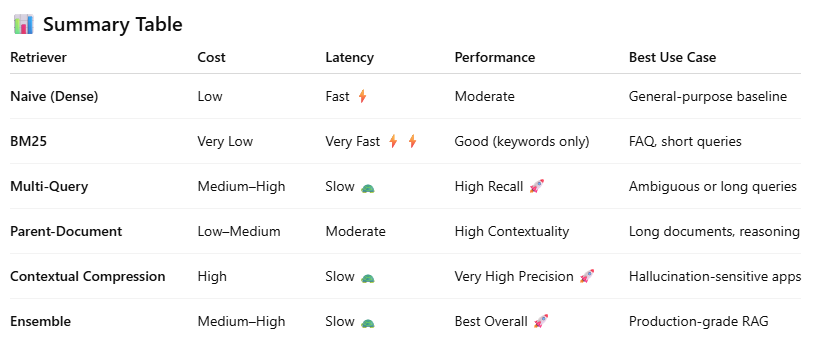


In summary, Ensemble with Semantic Chunking OFF yields the best result with highest score in Helpfulness with respect to the question.

Individual results with SC ON / OFF (links are in the run results in the notebook)

Naive with SC = OFF
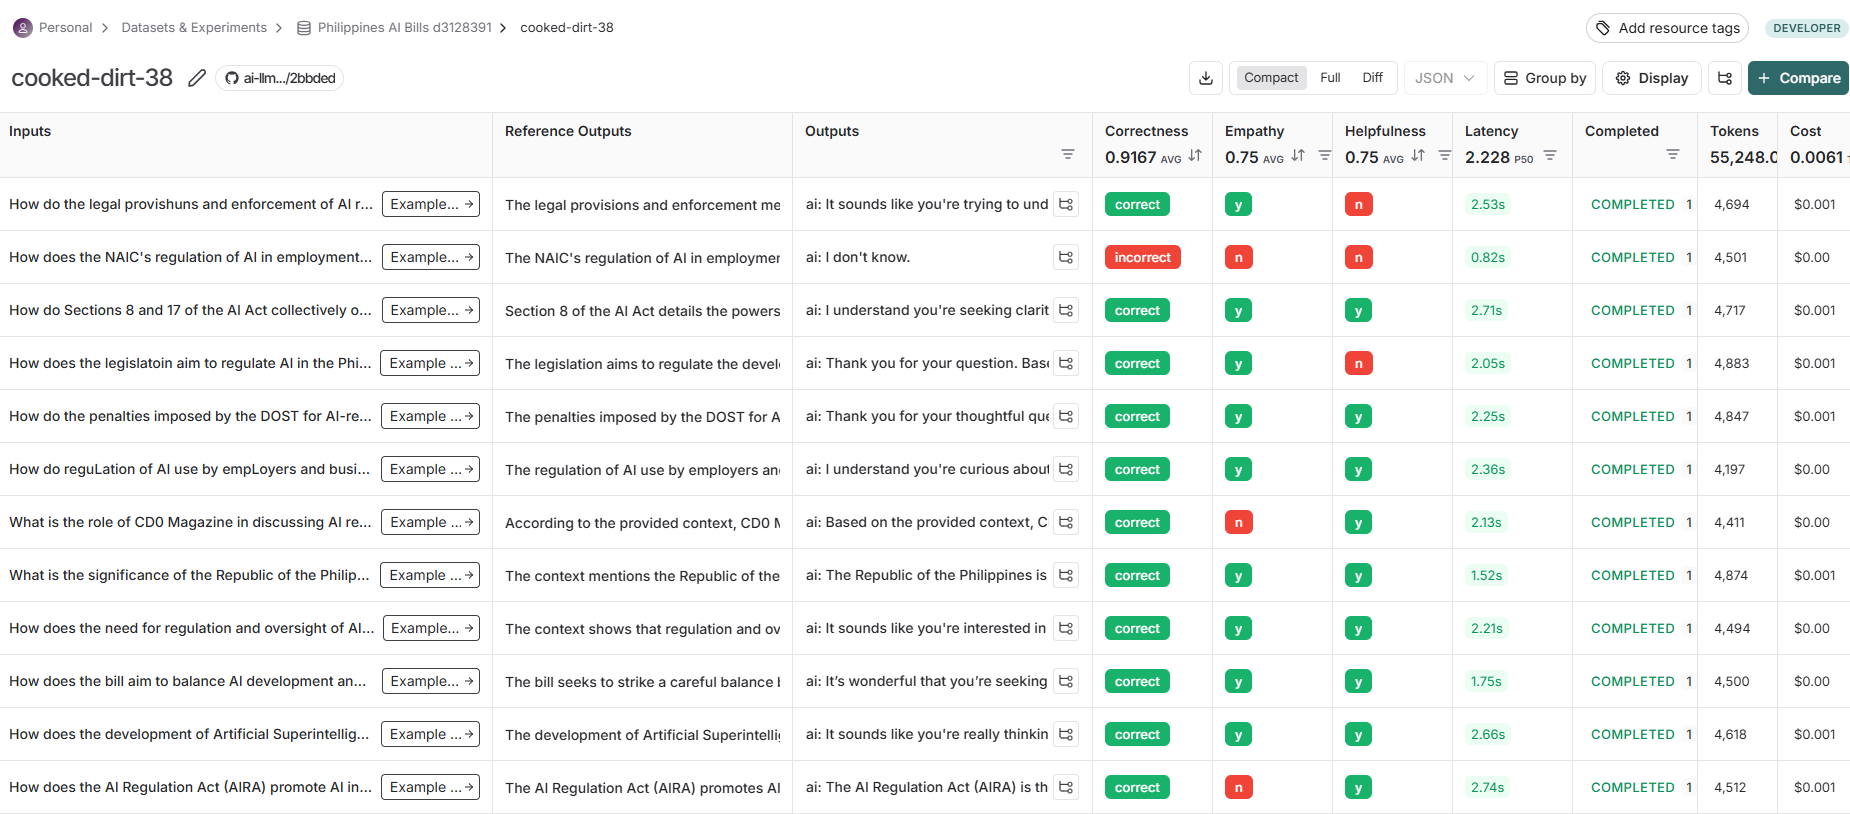

BM25 with SC = OFF
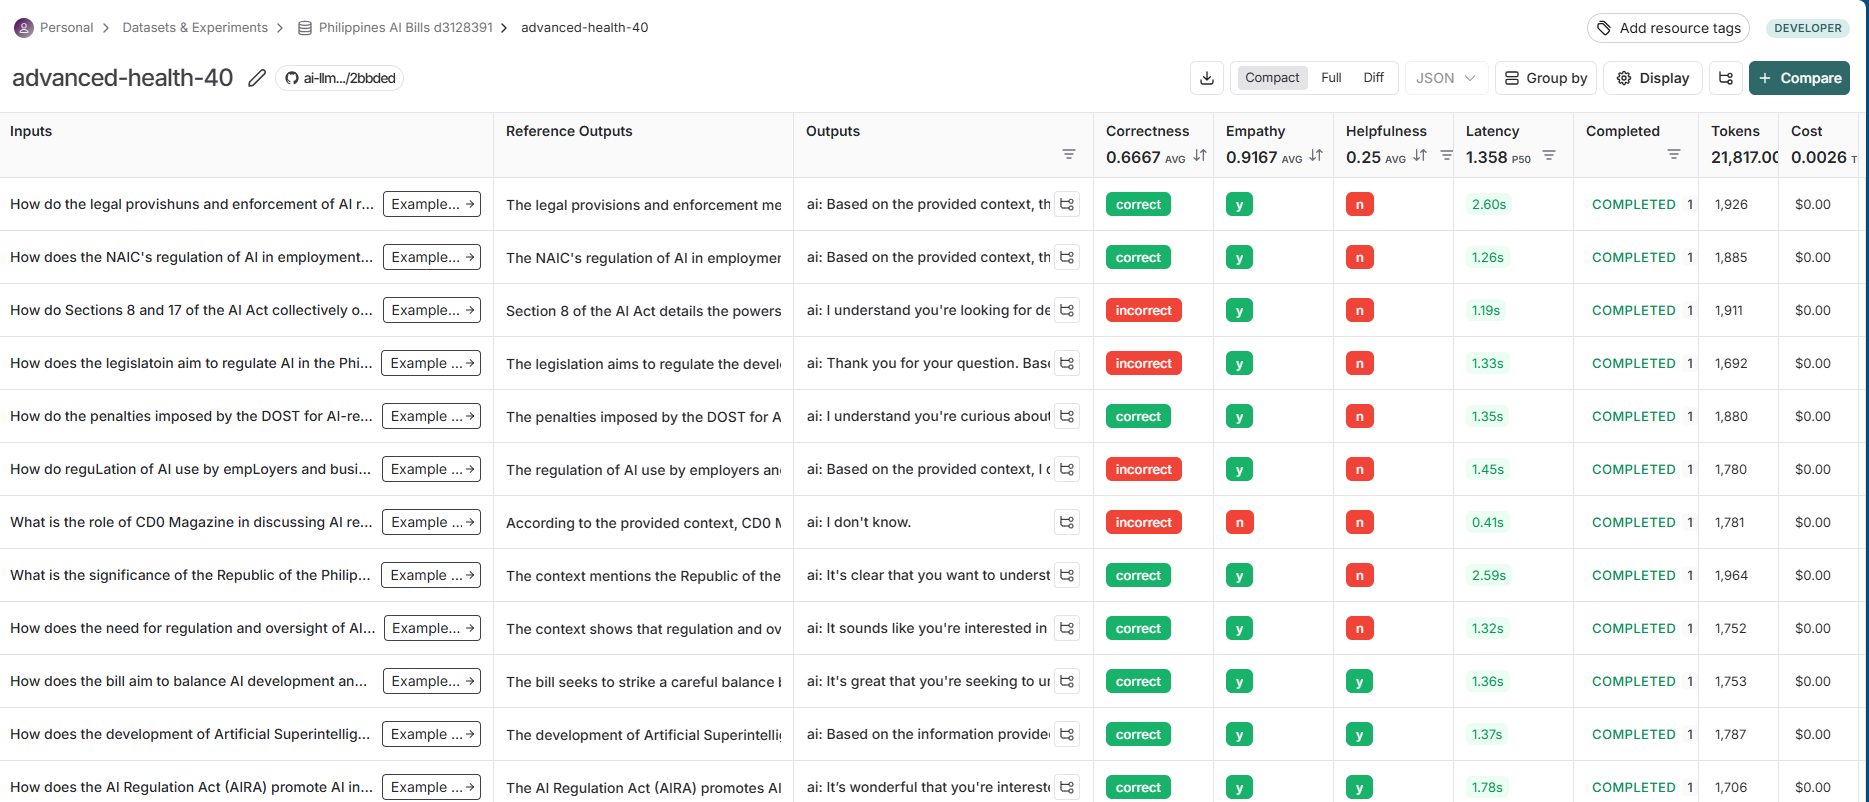

Multi-query with SC = OFF


Parent-Document with SC = OFF
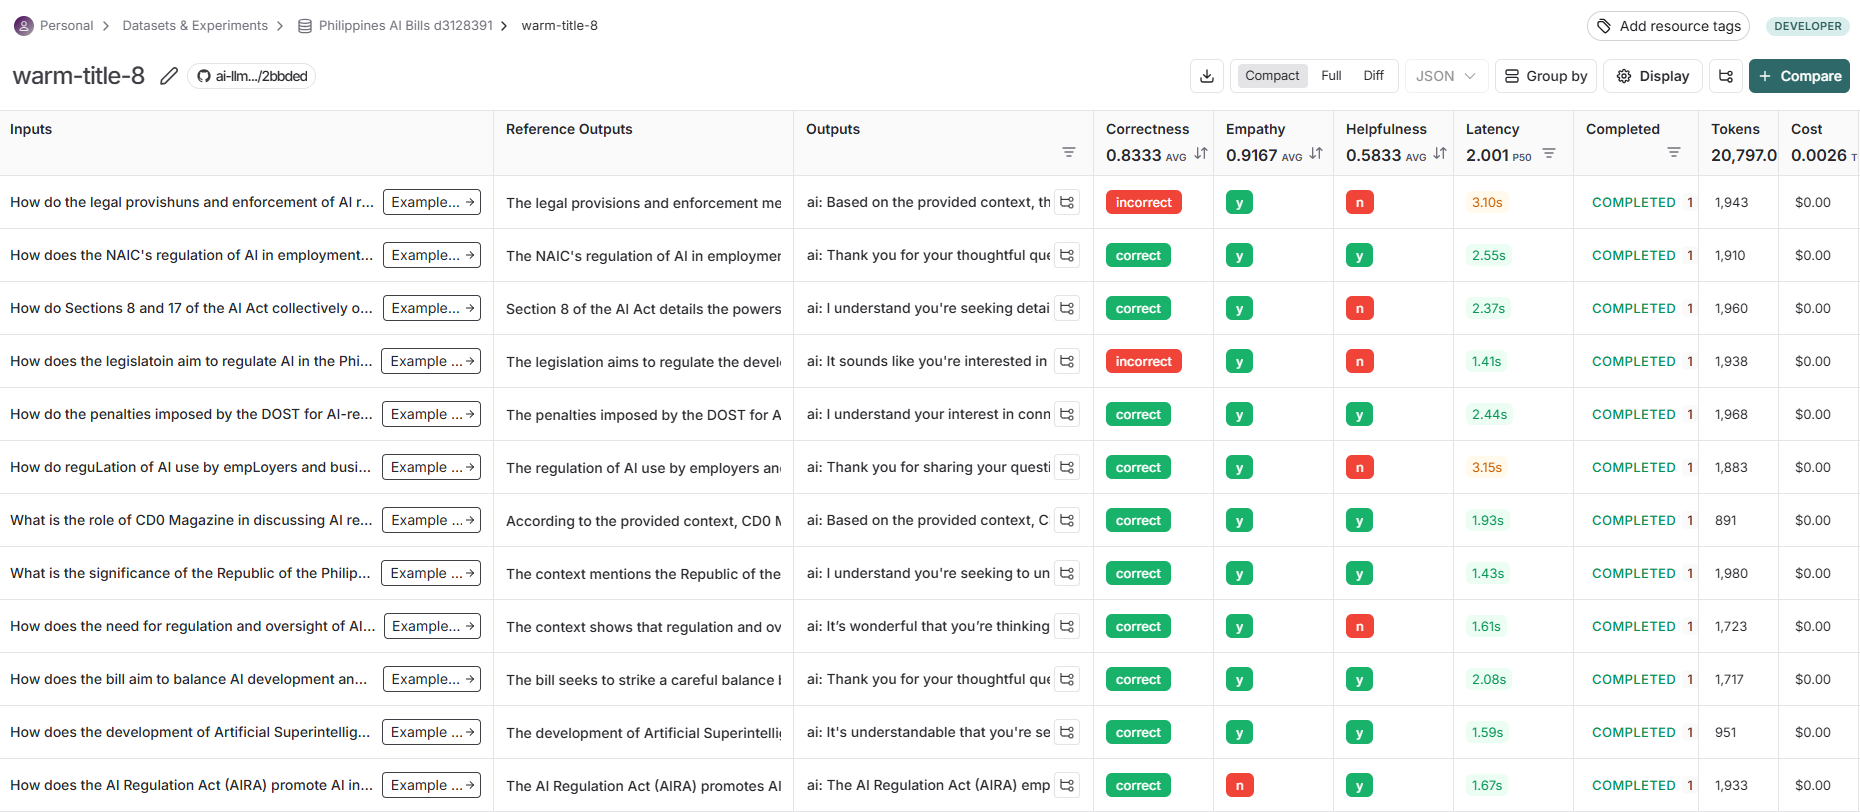

Contextual Compression with SC = OFF


Ensemble with SC = OFF


Naive with SC = ON
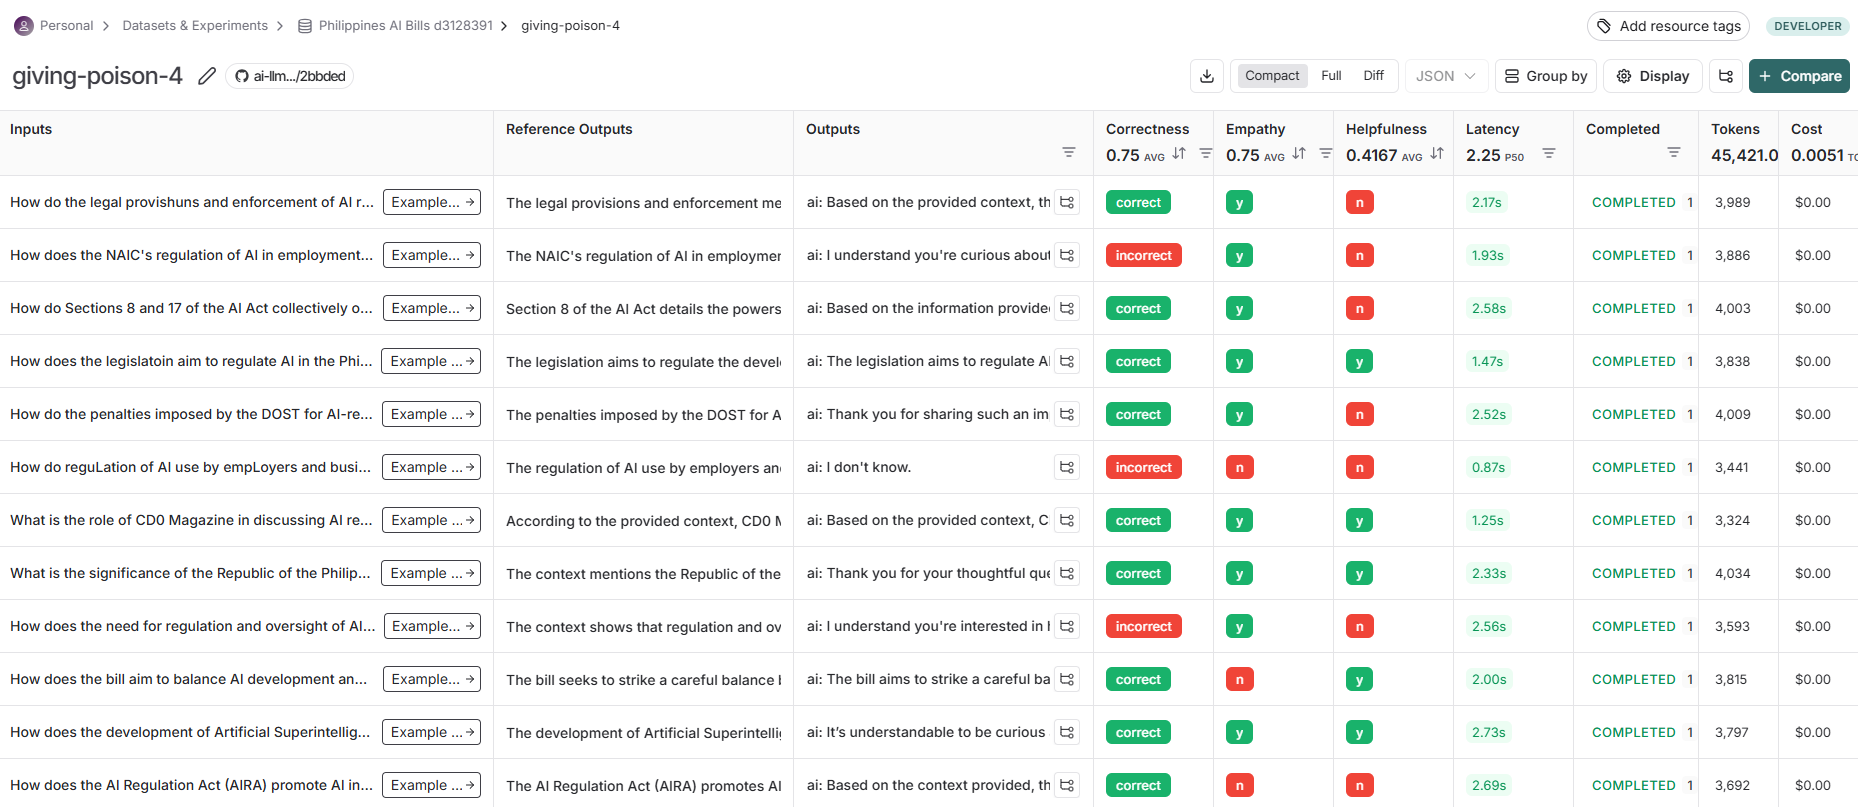

BM25 with SC = ON
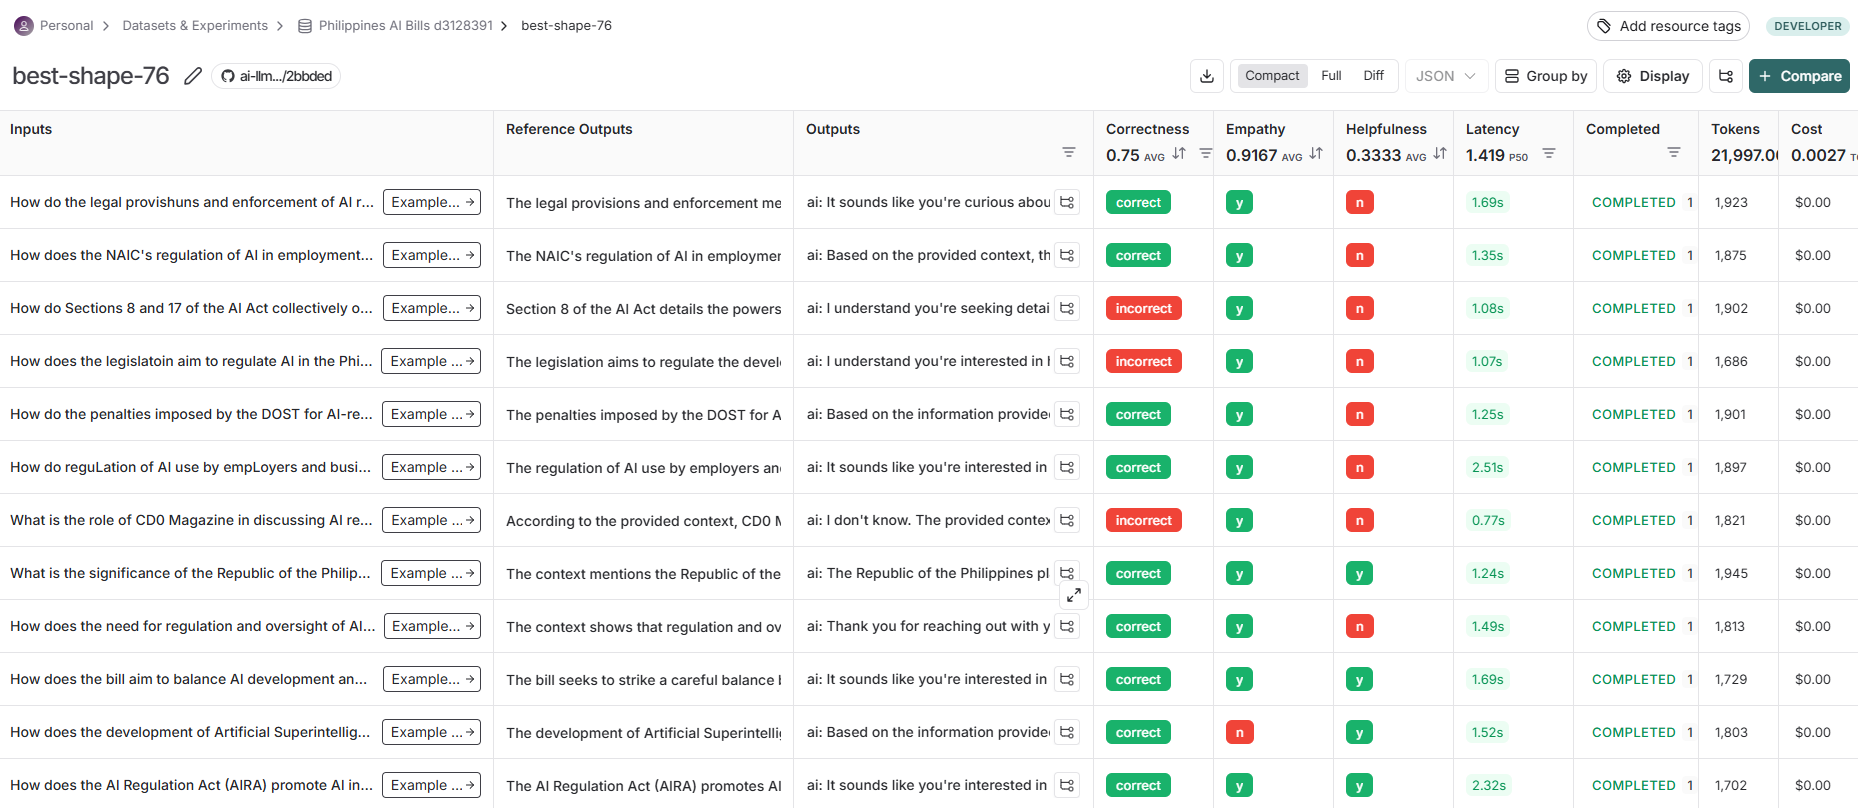

Multi-query with SC = ON
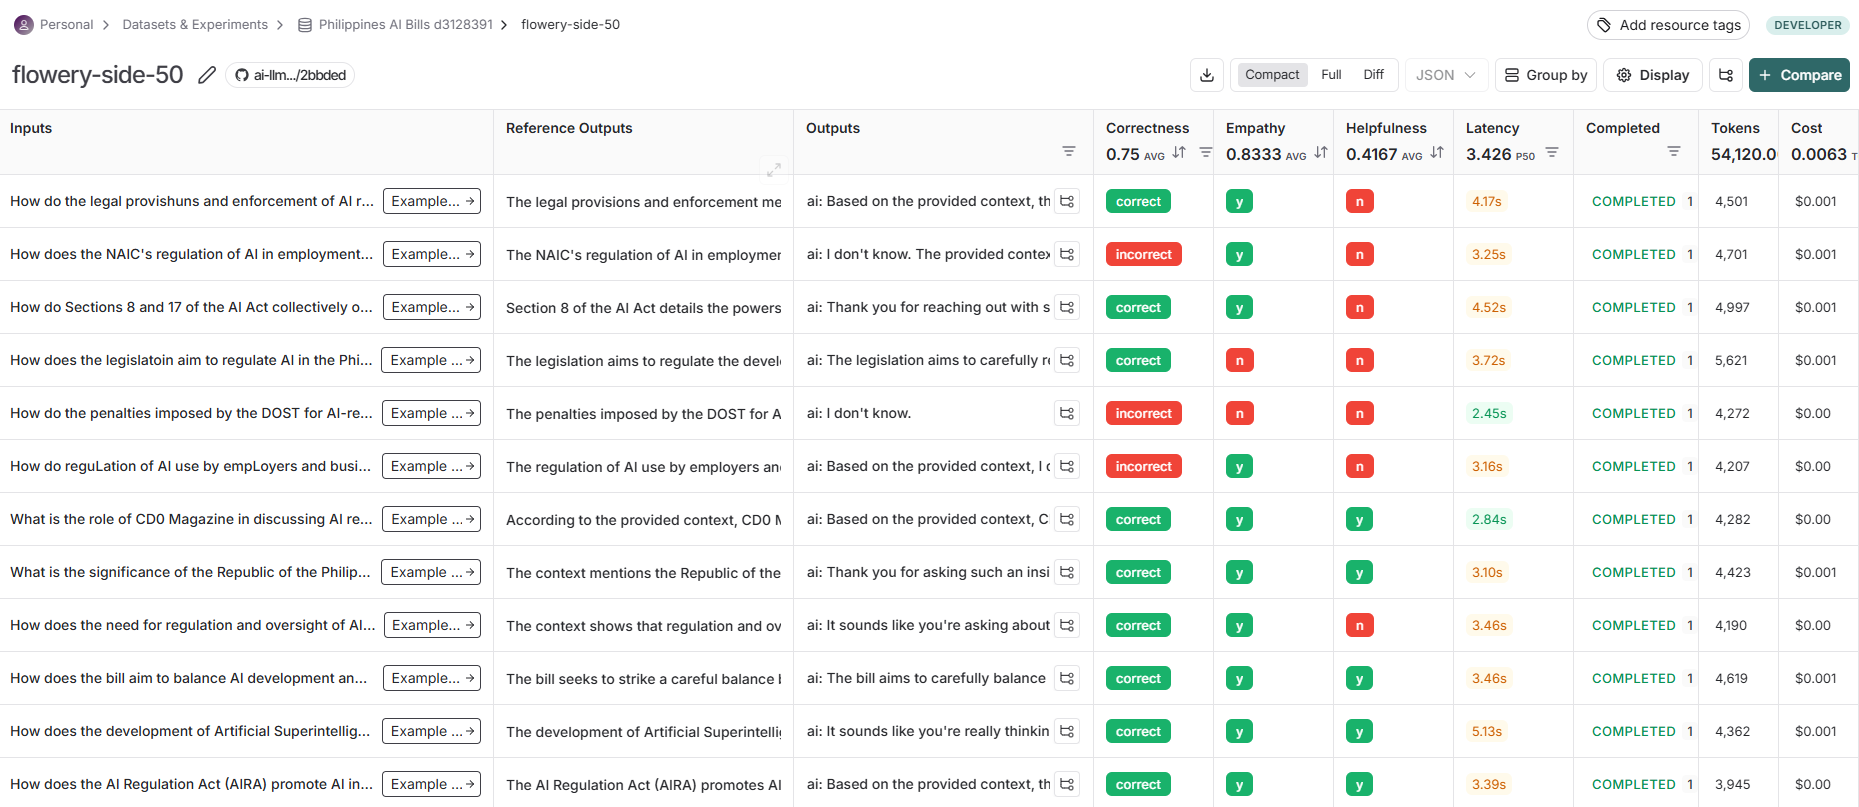

Parent-Document with SC = ON
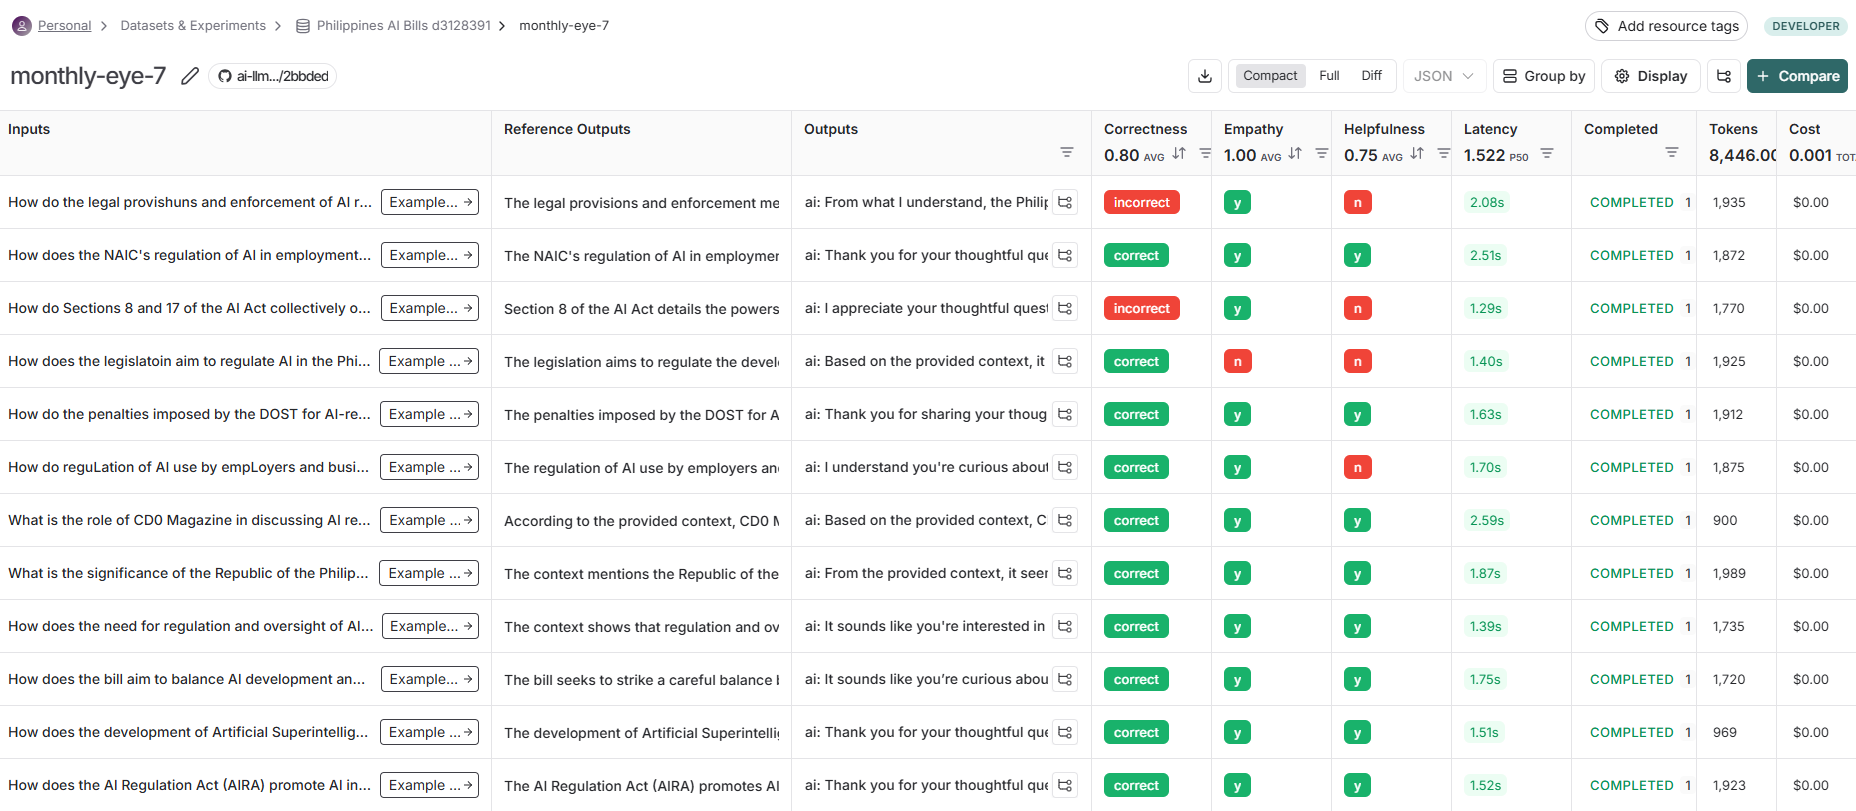

Contextual-Compression with SC = ON
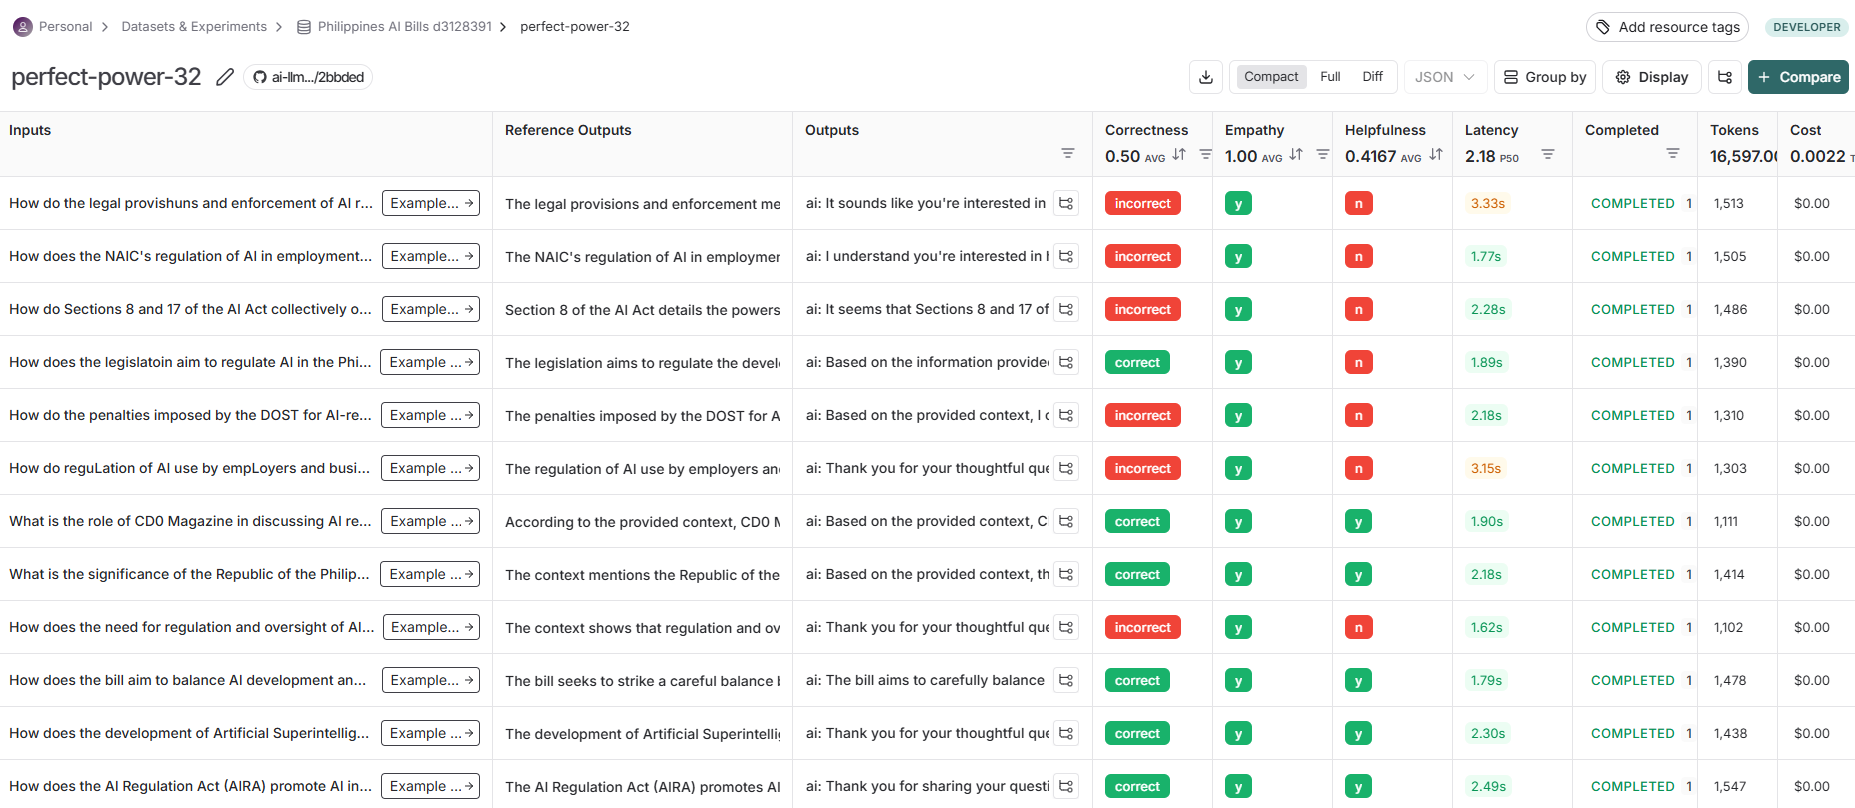

Ensemble with SC = ON
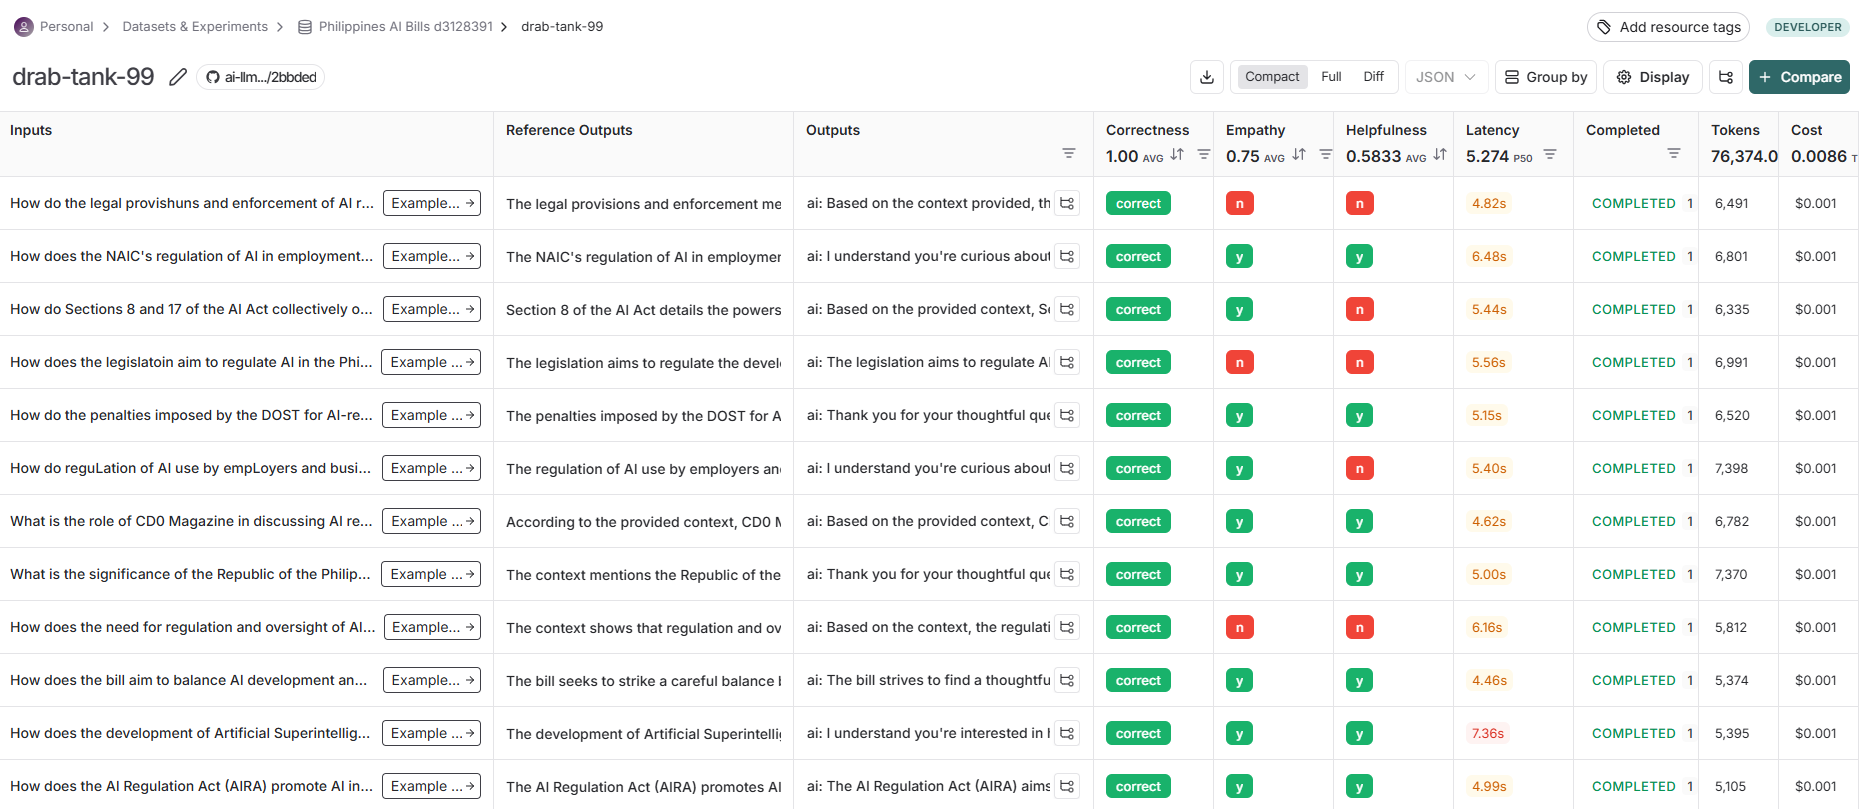




</div>